In [1]:
!pip install --upgrade --quiet git+https://github.com/dtonderski/DeepSudoku

In [2]:
!pip show deepsudoku

Name: deepsudoku
Version: 0.8.4
Summary: Solving Sudokus using a Neural Network assisted Monte-Carlo approach.
Home-page: https://github.com/dtonderski/DeepSudoku
Author: davton
Author-email: dtonderski@gmail.com
License: GNU GPLv3
Location: /usr/local/lib/python3.9/dist-packages
Requires: einops, numpy, py-sudoku, torch
Required-by: 


### Data
We use the previous_data list from 2. Initial SeResNet training, and split the data into train/val/test

In [3]:
import pickle as pkl
import random
import numpy as np

In [4]:
previous_data_path = '../models/initial/previous_data.pkl'
with open(previous_data_path, 'rb') as f:
    previous_data = pkl.load(f)
    
sudokus = [sudoku for x in previous_data for sudoku in x]

random.Random(5).shuffle(sudokus)

train_sudokus = [x for x in sudokus[:len(sudokus)//10*7]]
val_sudokus = [x for x in sudokus[len(sudokus)//10*7:len(sudokus)//10*9]]
test_sudokus = [x for x in sudokus[len(sudokus)//10*9:]]



### Models

In [5]:
import os
from deepsudoku.dsnn import se_resnet, transformer, sudoker, loss
from collections import defaultdict
import torch
import datetime
import time

In [6]:
models = {
    #model_name: lambda: model_function
    "SeResNet": lambda: se_resnet.SeResNet(10, 128, 32).cuda(),
    "ViTTiTransformer": lambda: transformer.Transformer(12,192,3,768,0).cuda(),
    "ViTTiSudoker": lambda: sudoker.Sudoker(12,192,3,768,0).cuda()
}

batch_sizes = {"SeResNet": 2048, "ViTTiTransformer": 512, "ViTTiSudoker": 512}

lrs = {"SeResNet": 1e-3, "ViTTiTransformer": 1e-5, "ViTTiSudoker": 1e-5}

In [7]:
model_name = "ViTTiSudoker"
network, batch_size = models[model_name](), batch_sizes[model_name]
optimizer = torch.optim.Adam(network.parameters())
loss_fn = loss.loss

In [8]:
model_path = f"../models/training/{model_name}"

if os.path.exists(model_path):
    print("Loading model")
    checkpoint = torch.load(model_path)
    network.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    losses = checkpoint['losses']
    cat_accs = checkpoint['cat_accs']
    bin_accs = checkpoint['bin_accs']
else:
    losses = defaultdict(list)
    cat_accs = defaultdict(list)
    bin_accs = defaultdict(list)

starting_epoch = len(losses['train'])
print(f"{starting_epoch=}")

Loading model
starting_epoch=180


### Training

In [9]:
from deepsudoku.utils import data_utils, network_utils
from deepsudoku.dsnn import evaluation

import torch

In [10]:
best_loss = np.Inf if len(losses) == 0 else losses['val'][-1]
epochs = 1000

In [11]:
train = True

if train:
    for epoch in range(starting_epoch, epochs):
        for phase in ['train', 'val']:
            if phase == 'train':
                augment = True                
                sudokus = train_sudokus
                random.shuffle(sudokus)
                network.train()
            else:
                augment = False
                sudokus = val_sudokus
                network.eval()

            batch_losses, batch_cat_accs, batch_bin_accs = [], [], []

            for i in range(0, len(sudokus), batch_size):
                batch_sudokus = sudokus[i:i+batch_size]

                x_np, y_np = data_utils.generate_numpy_batch(batch_sudokus, augment = augment)
                x, y = network_utils.numpy_batch_to_pytorch(x_np, y_np, 'cuda')
                y_pred = network(x)
                
                batch_p_loss, batch_v_loss = loss_fn(x, y_pred, y)    
                batch_loss = batch_v_loss + batch_p_loss
                batch_cat_acc = evaluation.categorical_accuracy(x, y, y_pred)
                batch_bin_acc = evaluation.binary_accuracy(y, y_pred)

                batch_losses.append(batch_loss.item())
                batch_cat_accs.append(batch_cat_acc)
                batch_bin_accs.append(batch_bin_acc)

                if phase == 'train':
                    optimizer.zero_grad()
                    batch_loss.backward()
                    torch.nn.utils.clip_grad_norm_(network.parameters(), 1)
                    optimizer.step()

                print(f"Phase {phase}, batch {min(i+batch_size, len(sudokus))}/{len(sudokus)}, {batch_p_loss.item()=:.4f}, " 
                      f"{batch_v_loss=:.4f}, {batch_cat_acc=:.4f}, {batch_bin_acc=:.4f}.", end = "\r")
            
            if phase == 'val':
                time.sleep(10)
            
            losses[phase].append(sum(batch_losses)/len(batch_losses))
            cat_accs[phase].append(sum(batch_cat_accs)/len(batch_cat_accs))
            bin_accs[phase].append(sum(batch_bin_accs)/len(batch_bin_accs))

        if losses['val'][-1] < best_loss:
            best_loss = losses['val'][-1]
            print("Saving the network!                                            "
                  "                                                               ")
            torch.save({
                'model_state_dict': network.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'cat_accs': cat_accs,
                'bin_accs': bin_accs,
                'losses': losses,
                }, f'{model_path}')


        print(f'Epoch {epoch}, loss = {losses["val"][-1]:.4f}, cat_acc = {cat_accs["val"][-1]:.4f}, '
              f'bin_acc = {bin_accs["val"][-1]:.4f}, time = {datetime.datetime.now()}.                                ')

KeyboardInterrupt: 

### Plotting

In [17]:
from matplotlib import pyplot as plt

In [20]:
losses_model_dict = {}
for model_name in ['SeResNet', 'ViTTiTransformer', 'ViTTiSudoker']:
    model_path = f"../models/training/{model_name}"

    checkpoint = torch.load(model_path)
    losses_model_dict[model_name] = checkpoint['losses']

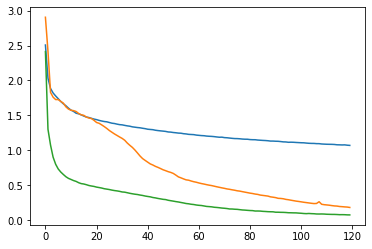

In [23]:
plt.plot(losses_model_dict['SeResNet']['train'][:120])
plt.plot(losses_model_dict['ViTTiTransformer']['train'][:120])
plt.plot(losses_model_dict['ViTTiSudoker']['train'][:120])
plt.show()
